# Create All Run Files

### Prepare everything

In [1]:
!pip install nose lightgbm trectools seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!bash -c 'cd ../../.. && make test-python'

make[1]: Entering directory '/workspace/trec-dl-21-ltr'
...
----------------------------------------------------------------------
Ran 3 tests in 29.979s

OK
make[1]: Leaving directory '/workspace/trec-dl-21-ltr'


In [15]:
import sys
from trectools import TrecQrel, TrecRun, TrecEval
sys.path.append('../python')

from util import write_run_file

def used_anchor_text(run):
    if 'marco-v1-no-anchor-no-orcas' in run.filename:
        return False
    names = ['all-50-features', 'marco-v1-all-121-features', 'marco-v1-no-orcas']
    for i in names:
        if i in run.filename:
            return True
    return False

def used_orcas_text(run):
    if 'marco-v1-no-anchor-no-orcas' in run.filename:
        return False
    names = ['marco-v1-all-121-features', 'marco-v1-no-anchor']
    for i in names:
        if i in run.filename:
            return True
    return False

def eval_run(run, qrels):
    return {
        'run': run.get_runid().replace('train-with-', ''),
        'used-anchor-text': used_anchor_text(run),
        'used-orcas-text': used_orcas_text(run),
        'MRR': TrecEval(run, qrels).get_reciprocal_rank(),
        'MRR (Unjudged Removed)': TrecEval(run, qrels).get_reciprocal_rank(removeUnjudged=True),
        'ndcg@5': TrecEval(run, qrels).get_ndcg(depth=5),
        'ndcg@5 (Unjudged Removed)': TrecEval(run, qrels).get_ndcg(depth=5,removeUnjudged=True),
        'ndcg@10': TrecEval(run, qrels).get_ndcg(depth=10),
        'ndcg@10 (Unjudged Removed)': TrecEval(run, qrels).get_ndcg(depth=10,removeUnjudged=True)
    }

# Create Rankings for All 50 Features

In [55]:
DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/'
MODELS=!ls $DIR |grep 'train-with'
FEATURE_FILES = ['2021_trec_dl_test.rerank', 'docv2_dev1.rerank', 'docv2_dev2.rerank']

In [6]:
MODELS

['train-with-1000-trees',
 'train-with-100-trees',
 'train-with-5000-trees',
 'train-with-5000-trees-var-02']

In [8]:
from tqdm import tqdm

for model in tqdm(MODELS):
    for feature_file in FEATURE_FILES:
        out_file = DIR + model + '/' + (feature_file.replace('.rerank', '').replace('_', '-')) + '-run-file.txt'
        write_run_file(
            model_file=DIR + model + '/LightGBM_model.txt',
            feature_file=DIR + feature_file, 
            system_name=model,
            out_file=out_file
        )

100%|██████████| 4/4 [19:33<00:00, 293.26s/it]


# Create Rankings for 41 Features Without Anchor Text

In [5]:
DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/2-no-anchor/'
MODELS=!ls $DIR |grep 'train-with'
FEATURE_FILES = ['2021_trec_dl_test.rerank', 'docv2_dev1.rerank', 'docv2_dev2.rerank']

In [6]:
MODELS

['train-with-1000-trees',
 'train-with-100-trees',
 'train-with-5000-trees',
 'train-with-5000-trees-var-02']

In [8]:
from tqdm import tqdm

for model in tqdm(MODELS):
    for feature_file in FEATURE_FILES:
        out_file = DIR + model + '/' + (feature_file.replace('.rerank', '').replace('_', '-')) + '-run-file.txt'
        write_run_file(
            model_file=DIR + model + '/LightGBM_model.txt',
            feature_file=DIR + feature_file, 
            system_name=model,
            out_file=out_file
        )

100%|██████████| 4/4 [04:54<00:00, 73.75s/it]


# Evaluation of Runs on DEV1

# Evaluation of Runs on DEV2

In [12]:
from trectools import TrecQrel, TrecRun, TrecEval

qrels = TrecQrel("/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/resources/docv2_dev2_qrels.tsv")

run_files = [TrecRun('/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/anserini-docv2-dev2-run-file.txt')]

DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/'
DIRS= ['all-50-features/', '2-no-anchor/']

for dir_name in DIRS:
    dir_name = DIR + dir_name
    models = !ls $dir_name |grep 'train-with'
    for model in tqdm(models):
        run_files += [TrecRun(dir_name + model + '/docv2-dev2-run-file.txt')]


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


In [33]:
# Expect from anserini docs an MRR of 0.1659
eval_run(run_files[0])

{'run': 'Anserini',
 'used-anchor-text': False,
 'MRR': 0.1658962272297557,
 'ndcg@5': 0.1661040831883196}

In [34]:
import pandas as pd

df = []
for run in tqdm(run_files):
    df += [eval_run(run)]

df = pd.DataFrame(df)
df.sort_values('MRR', ascending=False)

100%|██████████| 9/9 [00:13<00:00,  1.53s/it]


,run,used-anchor-text,MRR,ndcg@5
4,5000-trees-var-02,True,0.270415,0.284317
3,5000-trees,True,0.269390,0.282943
1,1000-trees,True,0.268794,0.282191
7,5000-trees,False,0.264467,0.277496
8,5000-trees-var-02,False,0.262023,0.275887
5,1000-trees,False,0.260175,0.273724
2,100-trees,True,0.247282,0.259980
6,100-trees,False,0.242383,0.256555
0,Anserini,False,0.165896,0.166104


In [35]:
df.sort_values('ndcg@5', ascending=False)

,run,used-anchor-text,MRR,ndcg@5
4,5000-trees-var-02,True,0.270415,0.284317
3,5000-trees,True,0.269390,0.282943
1,1000-trees,True,0.268794,0.282191
7,5000-trees,False,0.264467,0.277496
8,5000-trees-var-02,False,0.262023,0.275887
5,1000-trees,False,0.260175,0.273724
2,100-trees,True,0.247282,0.259980
6,100-trees,False,0.242383,0.256555
0,Anserini,False,0.165896,0.166104


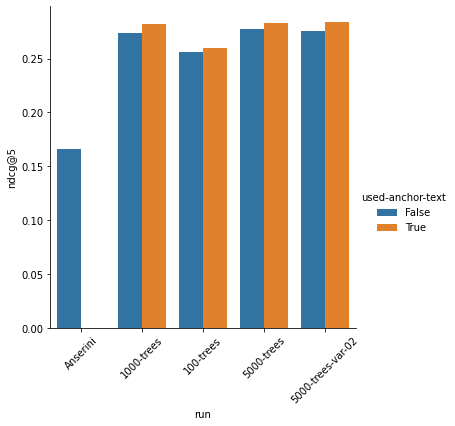

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=df, x='run', y='ndcg@5', hue='used-anchor-text', kind='bar')
plt.xticks(rotation=45)
None

# Double Check that all files are parseable with trec_eval

In [53]:
for f in run_files:
    print('\n\n\n' + f.filename)
    !trec_eval -m recip_rank $qrels.filename $f.filename




/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/anserini-docv2-dev2-run-file.txt
recip_rank            	all	0.1659



/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-1000-trees/docv2-dev2-run-file.txt
recip_rank            	all	0.2688



/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-100-trees/docv2-dev2-run-file.txt
recip_rank            	all	0.2473



/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-5000-trees/docv2-dev2-run-file.txt
recip_rank            	all	0.2694



/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-5000-trees-var-02/docv2-dev2-run-file.txt
recip_rank            	all	0.2704



/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/2-no-anchor/train-with-1000-trees/docv2-dev2-run-file.txt
recip

In [57]:
!trec_eval -m recip_rank $qrels.filename /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-100-trees-no-val/docv2-dev2-run-file.txt

recip_rank            	all	0.2473


In [60]:
!trec_eval -m recip_rank $qrels.filename /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-1000-trees-no-val/docv2-dev2-run-file.txt

recip_rank            	all	0.2688


# Submitted Files

- test topics
- test reranking for one topc

In [61]:
!md5sum /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-5000-trees-var-02/2021-trec-dl-test-run-file.txt

89d885c7bf076a84becb68635dfc7d20  /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-5000-trees-var-02/2021-trec-dl-test-run-file.txt


In [63]:
!md5sum /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/2-no-anchor/train-with-5000-trees-var-02/2021-trec-dl-test-run-file.txt

e524c301783b32caa6a5003b1820a50c  /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/2-no-anchor/train-with-5000-trees-var-02/2021-trec-dl-test-run-file.txt


In [64]:
!md5sum /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-1000-trees/2021-trec-dl-test-run-file.txt

7b8a65fe1eccfc2f9431e5a578704cc3  /mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/all-50-features/train-with-1000-trees/2021-trec-dl-test-run-file.txt


In [69]:
!ls 

webis-dl-1.txt	webis-dl-2.txt	webis-dl-3.txt


In [74]:
for i in range(3):
    t = TrecRun('../../../runs-submitted/webis-dl-' + str(i+1) + '.txt')
    print('\n\n\n' + t.get_runid())
    print(len(t.topics()))
    print(t.topics())




webis-dl-1
477
[2082, 7551, 7578, 13365, 19335, 23287, 29624, 30611, 42255, 47210, 62152, 64588, 67316, 67637, 68196, 70509, 76900, 83724, 87452, 89381, 100043, 104861, 105804, 107320, 112674, 112700, 116187, 118440, 119184, 120938, 120961, 121171, 122354, 122436, 123350, 124178, 126889, 130510, 131843, 135802, 138029, 141630, 143116, 144414, 146187, 148538, 156276, 156498, 156873, 168216, 168329, 169208, 174463, 177465, 180176, 182539, 183378, 190623, 191893, 194779, 194927, 195960, 200944, 201129, 207786, 226975, 230174, 234536, 237669, 239192, 239480, 240206, 242176, 245438, 248704, 252284, 252692, 252915, 253263, 255223, 255892, 258062, 258441, 265593, 265953, 272996, 273270, 276356, 277215, 281250, 282148, 287683, 288850, 290916, 292792, 293523, 294028, 295266, 300025, 300487, 300986, 301866, 303293, 303586, 305966, 311125, 312764, 315330, 315378, 315638, 316697, 316914, 322228, 323347, 324720, 330975, 332000, 332593, 333407, 337656, 363049, 364210, 366370, 390360, 395948, 3976

# Create rankings on MS-Marco V1

In [4]:
DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/marco-v1-all-121-features/'
MODELS=!ls $DIR |grep 'train-with'
FEATURE_FILES = ['2021_trec_dl_test.rerank', 'docv2_dev1.rerank']

In [5]:
MODELS

['train-with-1000-trees',
 'train-with-100-trees',
 'train-with-5000-trees',
 'train-with-5000-trees-var-02']

In [6]:
from tqdm import tqdm

DIRS= ['marco-v1-all-121-features/', 'marco-v1-no-anchor/', 'marco-v1-no-orcas/', 'marco-v1-no-anchor-no-orcas/']

for model in MODELS:
    for tmp_dir in DIRS:
        DIR = '/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/' + tmp_dir
        for feature_file in tqdm(FEATURE_FILES):
            out_file = DIR + model + '/' + (feature_file.replace('.rerank', '').replace('_', '-')) + '-run-file.txt'
            write_run_file(
                model_file=DIR + model + '/LightGBM_model.txt',
                feature_file=DIR + feature_file, 
                system_name=model,
                out_file=out_file
            )

100%|██████████| 2/2 [00:24<00:00, 12.37s/it]


In [10]:
from trectools import TrecQrel, TrecRun, TrecEval

qrels = TrecQrel("/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/resources-trec-dl-20/msmarco-docdev-qrels.tsv")

DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/'
DIRS= ['marco-v1-all-121-features/', 'marco-v1-no-anchor/', 'marco-v1-no-orcas/', 'v1-no-anchor-no-orcas']

# TODO: ADD Baseline
run_files = []

for dir_name in DIRS:
    dir_name = DIR + dir_name
    models = !ls $dir_name |grep 'train-with'
    for model in tqdm(models):
        run_files += [TrecRun(dir_name + model + '/docv2-dev1-run-file.txt')]

  0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: "/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/v1-no-anchor-no-orcasls: cannot access '/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/v1-no-anchor-no-orcas': No such file or directory/docv2-dev1-run-file.txt"

In [27]:
import pandas as pd

df = []
for run in tqdm(run_files):
    df += [eval_run(run,qrels)]

df = pd.DataFrame(df)
df.sort_values('MRR', ascending=False)

100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


,run,used-anchor-text,used-orcas-text,MRR,ndcg@5
6,5000-trees,False,True,0.353153,0.377771
4,1000-trees,False,True,0.352507,0.376777
2,5000-trees,True,True,0.352140,0.376584
0,1000-trees,True,True,0.351516,0.374667
3,5000-trees-var-02,True,True,0.350257,0.375069
7,5000-trees-var-02,False,True,0.349041,0.372642
10,5000-trees,True,False,0.345065,0.365906
8,1000-trees,True,False,0.341722,0.364292
11,5000-trees-var-02,True,False,0.341325,0.364257
5,100-trees,False,True,0.336447,0.359483


In [ ]:
# https://github.com/castorini/anserini/blob/master/docs/regressions-msmarco-doc.md
# BM25 0.2310 (MAP)
# BM25 (tuned) 0.2788 (MAP)
# BM25 (tuned) with docTTTTTquery 0.3270 (MRR)

# TODO Add: https://github.com/castorini/anserini/blob/master/docs/regressions-dl20-doc.md

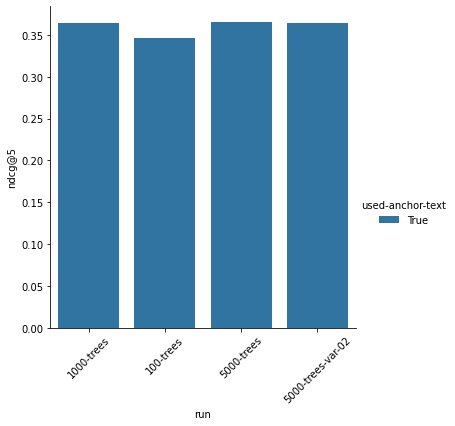

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=df[df['used-orcas-text'] == False], x='run', y='ndcg@5', hue='used-anchor-text', kind='bar')
plt.xticks(rotation=45)
None

In [11]:
from trectools import TrecQrel, TrecRun, TrecEval

qrels = TrecQrel("/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/resources-trec-dl-20/qrels.dl20-doc.txt")

DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/lightgbm/'
DIRS= ['marco-v1-all-121-features/', 'marco-v1-no-anchor/', 'marco-v1-no-orcas/', 'marco-v1-no-anchor-no-orcas/']

run_files = [TrecRun('/mnt/ceph/storage/data-in-progress/data-research/web-search/TREC-21/resources-trec-dl-20/msmarco-doctest2020-top100')]

for dir_name in DIRS:
    dir_name = DIR + dir_name
    models = !ls $dir_name |grep 'train-with'
    for model in tqdm(models):
        run_files += [TrecRun(dir_name + model + '/2021-trec-dl-test-run-file.txt')]

100%|██████████| 4/4 [00:00<00:00, 21.26it/s]


In [20]:
import pandas as pd

df = []
for run in tqdm(run_files):
    tmp_run = TrecRun()
    tmp_run.filename = run.filename
    tmp_run.run_data = run.run_data.copy()
    
    tmp_run.run_data = tmp_run.run_data[tmp_run.run_data['query'].astype(int).isin(qrels.topics())].reset_index()
    df += [eval_run(tmp_run,qrels)]

df = pd.DataFrame(df)
df.sort_values('MRR', ascending=False)

100%|██████████| 17/17 [00:01<00:00,  9.24it/s]


,run,used-anchor-text,used-orcas-text,MRR,MRR (Unjudged Removed),ndcg@5,ndcg@5 (Unjudged Removed),ndcg@10,ndcg@10 (Unjudged Removed)
3,5000-trees,True,True,0.944444,0.944444,0.593711,0.593711,0.595666,0.599775
11,5000-trees,True,False,0.933333,0.933333,0.611883,0.613424,0.595449,0.598091
12,5000-trees-var-02,True,False,0.929630,0.929630,0.598703,0.598703,0.582063,0.583402
9,1000-trees,True,False,0.918519,0.918519,0.608621,0.608621,0.590578,0.595161
15,5000-trees,False,False,0.918519,0.918519,0.618126,0.619667,0.601950,0.602238
8,5000-trees-var-02,False,True,0.916667,0.916667,0.618994,0.618994,0.596307,0.598974
1,1000-trees,True,True,0.916667,0.916667,0.604641,0.604641,0.596875,0.598618
4,5000-trees-var-02,True,True,0.913889,0.913889,0.604049,0.604049,0.593618,0.594501
5,1000-trees,False,True,0.912963,0.912963,0.614897,0.614897,0.598725,0.599729
16,5000-trees-var-02,False,False,0.911111,0.911111,0.622428,0.622428,0.591978,0.593552


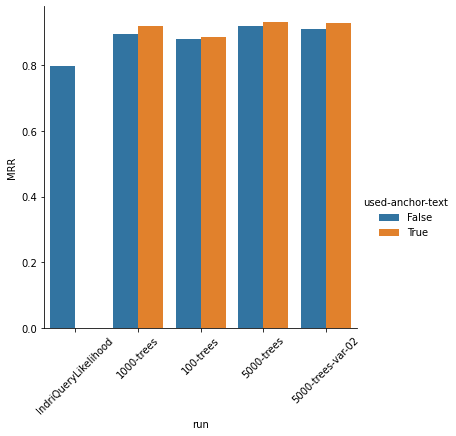

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=df[df['used-orcas-text'] == False], x='run', y='MRR', hue='used-anchor-text', kind='bar')
plt.xticks(rotation=45)
None